# 03. LangGraph를 활용한 Agent 구축

In [18]:
from IPython.core.completer import TypedDict
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_teddynote import logging
from sympy.physics.units import temperature

load_dotenv()
logging.langsmith("CH17-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph


## 도구(Tool) 사용하기

### TavilySearchResults

설명 - Tavily 검색 API를 쿼리하고 JSON 형식의 결과를 반환합니다. - 포괄적이고 정확하며 신뢰할 수 있는 결과에 최적화된 검색 엔진입니다.



In [19]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

tool.invoke("테드노트 랭체인 튜토리얼")

[{'title': ' - LangChain 한국어 튜토리얼 - WikiDocs',
  'url': 'https://wikidocs.net/book/14314',
  'content': ' - LangChain 한국어 튜토리얼🇰🇷 CH01 LangChain 시작하기 01. 설치 영상보고 따라하기 02. OpenAI API 키 발급 및 테스트 03. LangSmith 추적 설정 04. OpenAI API 사용(GPT-4o 멀티모달) 05.',
  'score': 0.60274047,
  'raw_content': '<랭체인LangChain 노트> - LangChain 한국어 튜토리얼🇰🇷 - WikiDocs\n<랭체인LangChain 노트> - LangChain 한국어 튜토리얼🇰🇷 CH01 LangChain 시작하기 01. 설치 영상보고 따라하기 02. OpenAI API 키 발급 및 테스트 03. LangSmith 추적 설정 04. OpenAI API 사용(GPT-4o 멀티모달) 05. LangChain Expression Language(LCEL) 06. LCEL 인터페이스 07. Runnable CH02 프롬프트(Prompt) 01. 프롬프트(Prompt) 02. 퓨샷 프롬프트(FewShotPromptTemplate) 03. LangChain Hub 04. 개인화된 프롬프트(Hub에 업로드) CH03 출력 파서(Output Parsers) 01. Pydantic 출력 파서(PydanticOutputParser) 02. 콤마 구분자 출력 파서(CommaSeparatedListOutputParser) 03. 구조화된 출력 파서(StructuredOuputParser) 04. JSON 출력 파서(JsonOutputParser) 05. 데이터프레임 출력 파서(PandasDataFrameOutputParser) 06. 날짜 형식 출력 파서(DatetimeOutputParser) 07. 열거형 출력 파서(EnumOutputParser) 08. 출력 수정 파서(Outpu

In [20]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

# State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)


### 도구 노드(Tool Node)

도구가 호출될 경우 실제로 실행할 수 있는 함수를 만들어야 함

가장 최근의 메시지를 확인하고 메시지에 tool_calls가 포함되어 있으면 도구를 호출하는 BasicToolNode를 구현합니다.

지금은 직접 구현하지만, 나중에는 LangGraph의 pre-built 되어있는 ToolNode 로 대체할 수 있습니다

In [21]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

### 조건부 엣지
도구 노드가 추가되면 conditional_edges를 정의할 수 있습니다.

Edges는 한 노드에서 다음 노드로 제어 흐름을 라우팅합니다.

Conditional edges는 일반적으로 "if" 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 라우팅합니다. 이러한 함수는 현재 그래프 state를 받아 다음에 호출할 Node 를 나타내는 문자열 또는 문자열 목록 을 반환합니다.

아래에서는 route_tools라는 라우터 함수를 정의하여 챗봇의 출력에서 tool_calls를 확인합니다.

이 함수를 add_conditional_edges를 호출하여 그래프에 제공하면, chatbot 노드가 완료될 때마다 이 함수를 확인하여 다음으로 어디로 갈지 결정합니다.

조건은 도구 호출이 있으면 tools로, 없으면 END로 라우팅됩니다.

**참고**

- langgraph 에 pre-built 되어 있는 tools_condition 으로 대체할 수 있습니다.

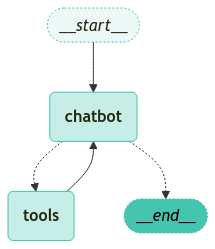

In [22]:
from langchain_teddynote.graphs import visualize_graph
from langgraph.constants import END, START


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END

# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

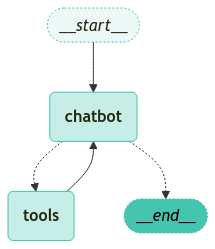

In [23]:
# 그래프 시각화
visualize_graph(graph)

In [24]:
from langchain_teddynote.messages import display_message_tree

question = "테디노트 YouTube"

for event in graph.stream({"messages": [("user", question)]}):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        display_message_tree(value["messages"][-1])


STEP: chatbot

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                id: "call_1bMrp7pwMjnwGc5Jw66zNtIa"
                function: {"arguments": "{"query":"테디노트 YouTube"}", "name": "tavily_web_search"}
                type: "function"
        refusal: None
    response_metadata:
        token_usage:
            completion_tokens: 23
            prompt_tokens: 97
            total_tokens: 120
            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
        model_name: "gpt-4o-mini-2024-07-18"
        system_fingerprint: "fp_d02d531b47"
        finish_reason: "tool_calls"
        logprobs: None
    type: "ai"
    name: None
    id: "run-925d7dcd-1a38-4105-954c-da7998c0ce9d-0"
    example: False
    tool_calls:
        index [0]
            name: "tavily_web_search"
            args